In [22]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import feather
from random import randint
import io

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns
import cv2

# sklearn model imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

In [23]:
import feather
df = feather.read_dataframe('df_transformed1.feather')
df.shape
df.head(1)

(20580, 15)

,id,image,annotation,breed,breed_label,pose,width,height,box_xmin,box_ymin,box_xmax,box_ymax,scene_img,crop_img,masked_img
0,n02085620_10074,Images/n02085620-Chihuahua/n02085620_10074.jpg,Annotation/n02085620-Chihuahua/n02085620_10074,1,Chihuahua,Unspecified,333,500,25,10,276,498,Scene/Chihuahua/n02085620_10074.png,Cropped/Chihuahua/n02085620_10074.jpg,Masked/Chihuahua/n02085620_10074.png


### Split images in train and test folders (use of  flow_from_directory)

In [24]:
X=df
y=df.loc[:, 'breed_label'].values
y = pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y )
df.shape
X_train.shape
X_test.shape

(20580, 15)

(15435, 15)

(5145, 15)

#### Creating parent folders

In [25]:
import os

folders =  ['Keras', 'Keras_train', 'Keras_test']
for folder in folders:
    try:os.mkdir(folder)
    except:pass
    
    for breed in df['breed_label'].unique():
        try:os.mkdir(folder+'/'+breed)
        except:pass
        
from shutil import copyfile, copy, copytree
def copy_keras_dir(x, dest_folder):
    src = x['crop_img']
    dest = src.replace('Cropped', dest_folder)
    copyfile(src, dest)

# skip , takes around 1 min to run 
if False:
    X_train.apply(lambda x: copy_keras_dir(x, 'Keras_train' ), axis = 1)
    X_test.apply(lambda x: copy_keras_dir(x, 'Keras_test' ), axis = 1)

###  Create subfolders for all breeds (or smaller set of specific breeds)

In [120]:
all_breeds = df['breed_label'].unique()
three_breeds = ['Newfoundland',  'Pembroke', 'Samoyed']
twelve_breeds=['Newfoundland','giant_schnauzer', 'Maltese_dog', 'pembroke', 'Siberian_husky', 'Eskimo_dog','redbone', 'Chihuahua', 'African_hunting_dog', 'golden_retriever', 'cocker_spaniel', 'Samoyed']

# Delete Keras_small folder before reducing the set 
reduced_set = twelve_breeds

for breed in reduced_set:
    for folder in ['Keras_train', 'Keras_test']:
        src = folder+'\\'+breed
        dest = 'Keras_small\\'+folder+'\\'+breed
        try:copytree(src, dest)
        except:pass
    
mask = df['breed_label'].isin(reduced_set)

small_set_folder = 'Keras_small\\'
if small_set_folder!='':
    nb_breeds = len(reduced_set)
else:
    nb_breeds = df['breed'].unique().max()
print(nb_breeds ,'unique breeds')

'Keras_small\\Keras_train\\giant_schnauzer'

'Keras_small\\Keras_test\\giant_schnauzer'

'Keras_small\\Keras_train\\Maltese_dog'

'Keras_small\\Keras_test\\Maltese_dog'

'Keras_small\\Keras_train\\Siberian_husky'

'Keras_small\\Keras_test\\Siberian_husky'

'Keras_small\\Keras_train\\Eskimo_dog'

'Keras_small\\Keras_test\\Eskimo_dog'

'Keras_small\\Keras_train\\redbone'

'Keras_small\\Keras_test\\redbone'

'Keras_small\\Keras_train\\Chihuahua'

'Keras_small\\Keras_test\\Chihuahua'

'Keras_small\\Keras_train\\African_hunting_dog'

'Keras_small\\Keras_test\\African_hunting_dog'

'Keras_small\\Keras_train\\golden_retriever'

'Keras_small\\Keras_test\\golden_retriever'

'Keras_small\\Keras_train\\cocker_spaniel'

'Keras_small\\Keras_test\\cocker_spaniel'

12 unique breeds


In [121]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend
backend.set_image_dim_ordering('th')
from keras.preprocessing.image import ImageDataGenerator

In [122]:
def conv_default(filters):
    return Conv2D(filters, kernel_size=3, activation='relu', padding='same')
def pool_default():
    return (MaxPooling2D(pool_size=(2, 2),  strides=(2, 2)))

img_size =128
color = 1
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(color*2 +1, img_size, img_size), padding='same'))
model.add(pool_default())

model.add(conv_default(32))
model.add(conv_default(32))
model.add(pool_default())
          
model.add(conv_default(32))
model.add(conv_default(32))
model.add(pool_default())

model.add(conv_default(64))
model.add(conv_default(64))
model.add(pool_default())

model.add(conv_default(64))
model.add(conv_default(64))
model.add(pool_default())
          
model.add(conv_default(128))
model.add(pool_default())


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(nb_breeds))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy' ,
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 32, 128, 128)      896       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 32, 64, 64)        9248      
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 32, 64, 64)        9248      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 32)        9248      
__________

In [123]:
#Help from sources :
#https://keras.io/preprocessing/image/
#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

batch_size = 100

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
if color ==1 :
    color_mode = "rgb"
else:
    color_mode = "grayscale"
print('Train data:')
train_generator = train_datagen.flow_from_directory(
    small_set_folder+'Keras_train',  # this is the target directory
    target_size=(img_size, img_size),  # all images will be resized to 150x150
    color_mode=color_mode,
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
print('Test data:')
validation_generator = test_datagen.flow_from_directory(
        directory= small_set_folder+'Keras_test',
        target_size=(img_size, img_size),
        color_mode=color_mode,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Train data:
Found 1591 images belonging to 12 classes.
Test data:
Found 532 images belonging to 12 classes.


In [124]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights_4.hdf5', monitor ='val_loss', save_best_only=True)
early_stopping_monitor = EarlyStopping(patience = 4)

In [125]:
STEP_SIZE_TRAIN=3*train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN*batch_size, 'images generated per epoch')
training =model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=STEP_SIZE_VALID
        , callbacks=[early_stopping_monitor]
        , max_queue_size=30
        , workers=4
        , use_multiprocessing=False
)

4700 images generated per epoch
Epoch 1/20
47/47 [==============================] - 28s 599ms/step - loss: 2.4549 - acc: 0.1145 - val_loss: 2.2960 - val_acc: 0.1440
Epoch 2/20
47/47 [==============================] - 26s 543ms/step - loss: 2.2755 - acc: 0.1782 - val_loss: 2.0861 - val_acc: 0.2477
Epoch 3/20
47/47 [==============================] - 26s 549ms/step - loss: 2.1187 - acc: 0.2274 - val_loss: 2.0447 - val_acc: 0.2593
Epoch 4/20
47/47 [==============================] - 26s 550ms/step - loss: 1.9956 - acc: 0.2660 - val_loss: 1.9140 - val_acc: 0.2963
Epoch 5/20
47/47 [==============================] - 26s 543ms/step - loss: 1.8644 - acc: 0.3075 - val_loss: 1.8029 - val_acc: 0.3449
Epoch 6/20
47/47 [==============================] - 26s 545ms/step - loss: 1.8220 - acc: 0.3296 - val_loss: 1.8229 - val_acc: 0.3704
Epoch 7/20
47/47 [==============================] - 26s 543ms/step - loss: 1.8086 - acc: 0.3359 - val_loss: 1.6436 - val_acc: 0.3960
Epoch 8/20
47/47 [===================

In [126]:
model.save_weights('last_weights_12breeds.hdf5') 

### Display score changes through epochs

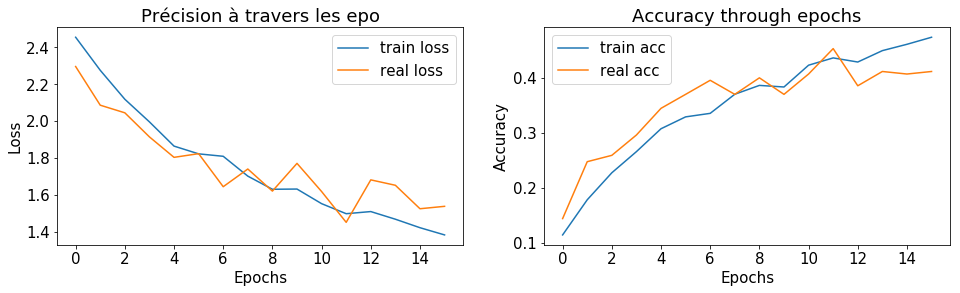

In [128]:
fig_size(16,4, 15)
fig, axes  = plt.subplots(1, 2, sharey=False, sharex=False)
silent = axes[0].plot(training.history['loss'], label='train loss')
silent = axes[0].plot(training.history['val_loss'], label='real loss')
silent = axes[0].legend()
silent = legend(axes[0], 'Précision à travers les epo', 'Epochs', 'Loss')

silent = axes[1].plot(training.history['acc'], label='train acc')
silent = axes[1].plot(training.history['val_acc'], label='real acc')
silent = axes[1].legend()
silent = legend(axes[1], 'Accuracy through epochs', 'Epochs', 'Accuracy')

## Results in details

In [129]:
model.load_weights('last_weights_12breeds.hdf5')
pred = model.predict_generator(validation_generator)
pred_confidence = np.round(pred*10)/10

In [130]:
pred_classes=np.argmax(pred,axis=1)
true_classes=validation_generator.classes

labels_dict = (train_generator.class_indices)
labels_dict = dict((v,k) for k,v in labels_dict.items())
labels = list(labels_dict.values())

pred_labels =  [labels_dict[k] for k in pred_classes]
true_labels =  [labels_dict[k] for k in true_classes]

Confusion matrix, without normalization
[[32  1  0  1  4  1  0  1  0  1  0  1]
 [ 2  5  0  7  1  5  2  6  1  0  3  6]
 [ 0  2  5  2  0  1  1 26  1  0  0  0]
 [ 0  4  0 45  2  2  9  1  0  0  0  0]
 [ 1  0  0  0 42  0  0  1  0  5  0  0]
 [ 0  3  0  1  1 29  0  6  0  0  2  3]
 [ 0  0  0 19  0  1 34  1  0  0  0  0]
 [ 1  2  4  4  3  4  3 24  0  2  0  1]
 [ 1  0  0  5 11  3  0  3  4  4  1  8]
 [ 3  0  0  0 28  0  0  0  1  7  0  0]
 [ 2  2  0  5  0  8  0  1  4  0  3 13]
 [ 1  0  0  1  1  5  0  0  2  0  6 21]]


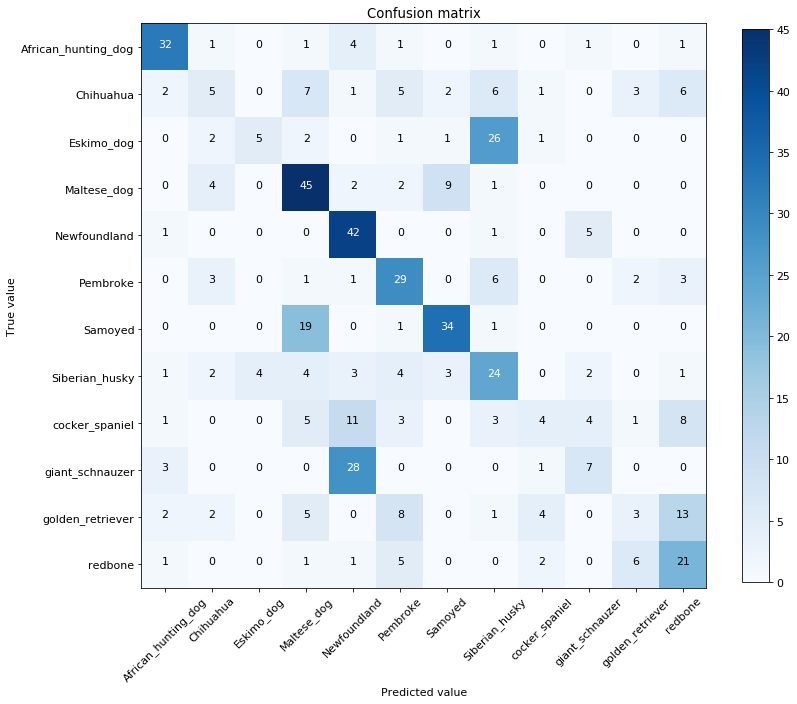

In [134]:
fig_size(12,12, 11)
cm = confusion_matrix(true_labels, pred_labels, labels =labels)
silent =plot_confusion_matrix(cm, labels)

In [135]:
df_results = pd.DataFrame( )
df_results['true_breed'] = true_labels
df_results['pred_breed'] = pred_labels
df_results['true_image'] = validation_generator.filenames 
df_results['true_image'] = validation_generator.directory+'\\'+df_results['true_image']
df_confidence = pd.DataFrame(pred_confidence, columns=labels)
df_results = df_results.join(df_confidence)
df_results.shape
df_results.sample(4)

(532, 15)

,true_breed,pred_breed,true_image,African_hunting_dog,Chihuahua,Eskimo_dog,Maltese_dog,Newfoundland,Pembroke,Samoyed,Siberian_husky,cocker_spaniel,giant_schnauzer,golden_retriever,redbone
361,Siberian_husky,Newfoundland,Keras_small\Keras_test\Siberian_husky\n0211018...,0.000,0.000,0.200,0.000,0.300,0.000,0.000,0.200,0.100,0.200,0.000,0.000
172,Maltese_dog,Maltese_dog,Keras_small\Keras_test\Maltese_dog\n02085936_8...,0.000,0.100,0.000,0.400,0.000,0.000,0.200,0.000,0.200,0.000,0.100,0.000
141,Maltese_dog,Maltese_dog,Keras_small\Keras_test\Maltese_dog\n02085936_3...,0.000,0.000,0.100,0.700,0.000,0.000,0.200,0.000,0.000,0.000,0.000,0.000
450,giant_schnauzer,giant_schnauzer,Keras_small\Keras_test\giant_schnauzer\n020971...,0.000,0.000,0.000,0.000,0.400,0.000,0.000,0.000,0.000,0.500,0.000,0.000


## Displaying some fail exemples 

,true_breed,pred_breed,true_image,African_hunting_dog,Chihuahua,Eskimo_dog,Maltese_dog,Newfoundland,Pembroke,Samoyed,Siberian_husky,cocker_spaniel,giant_schnauzer,golden_retriever,redbone
29,African_hunting_dog,redbone,Keras_small\Keras_test\African_hunting_dog\n02...,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.100,0.000,0.200,0.500


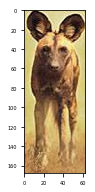

,true_breed,pred_breed,true_image,African_hunting_dog,Chihuahua,Eskimo_dog,Maltese_dog,Newfoundland,Pembroke,Samoyed,Siberian_husky,cocker_spaniel,giant_schnauzer,golden_retriever,redbone
504,redbone,African_hunting_dog,Keras_small\Keras_test\redbone\n02090379_1736.jpg,0.900,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


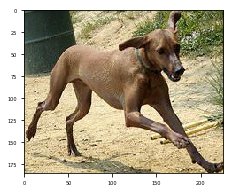

In [139]:
fig_size(5,3, 5)
my_query = '({3} == "{0}" and {2} == "{1}") or ({3} =="{1}" and {2} =="{0}")'.format(labels[0], labels[-1], 'pred_breed', 'true_breed')
df_worst_errors = df_results.query(my_query)
#df_worst_errors = df_worst_errors.join(full_data_df).join(X)

for index, row in df_worst_errors.iterrows() :
    df_worst_errors.loc[[index]]
    img = cv2.imread(row['true_image']) #IMREAD_UNCHANGED to keep 4th channel with transparency
    imshow(img)
    